Download the Brazilian coins dataset, adapted from [Kaggle -Ronaldo S Moura](https://www.kaggle.com/ronaldosm96/brazilian-coins-dataset) as a split in subdirectories for the coin classes.

In [ ]:
!wget https://edshare.gcu.ac.uk/id/document/61314 \
      -O /content/Brazilian_coins_dataset_ClassSplit.zip

--2022-05-02 02:18:22--  https://edshare.gcu.ac.uk/id/document/61314
Resolving edshare.gcu.ac.uk (edshare.gcu.ac.uk)... 193.62.226.109
Connecting to edshare.gcu.ac.uk (edshare.gcu.ac.uk)|193.62.226.109|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://edshare.gcu.ac.uk/9958/1/Brazilian_coins_dataset_ClassSplit.zip [following]
--2022-05-02 02:18:23--  https://edshare.gcu.ac.uk/9958/1/Brazilian_coins_dataset_ClassSplit.zip
Connecting to edshare.gcu.ac.uk (edshare.gcu.ac.uk)|193.62.226.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33540668 (32M) [application/zip]
Saving to: ‘/content/Brazilian_coins_dataset_ClassSplit.zip’

/content/Brazilian_ 100%[===================>]  31.99M  7.57MB/s    in 6.8s    

2022-05-02 02:18:30 (4.74 MB/s) - ‘/content/Brazilian_coins_dataset_ClassSplit.zip’ saved [33540668/33540668]



The zip file is next extracted to the current directory, producing `train` and `validation` subdirectories. In turn each contains `005`, `010`,`025`,`050` and `100` subdirectories for each coin type (value in `centavos` of Brazilian real).

In [ ]:
import os
import zipfile
#extract it. Directories structure as train/val is created
local_zip = '/content/Brazilian_coins_dataset_ClassSplit.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()
os.remove('./split_in_folders.c') #C code used to re-arrange the original images in subfolders

Define directories:

In [ ]:
base_dir = './'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

We have a total of 765 training images and 300 validation images. They look like this:

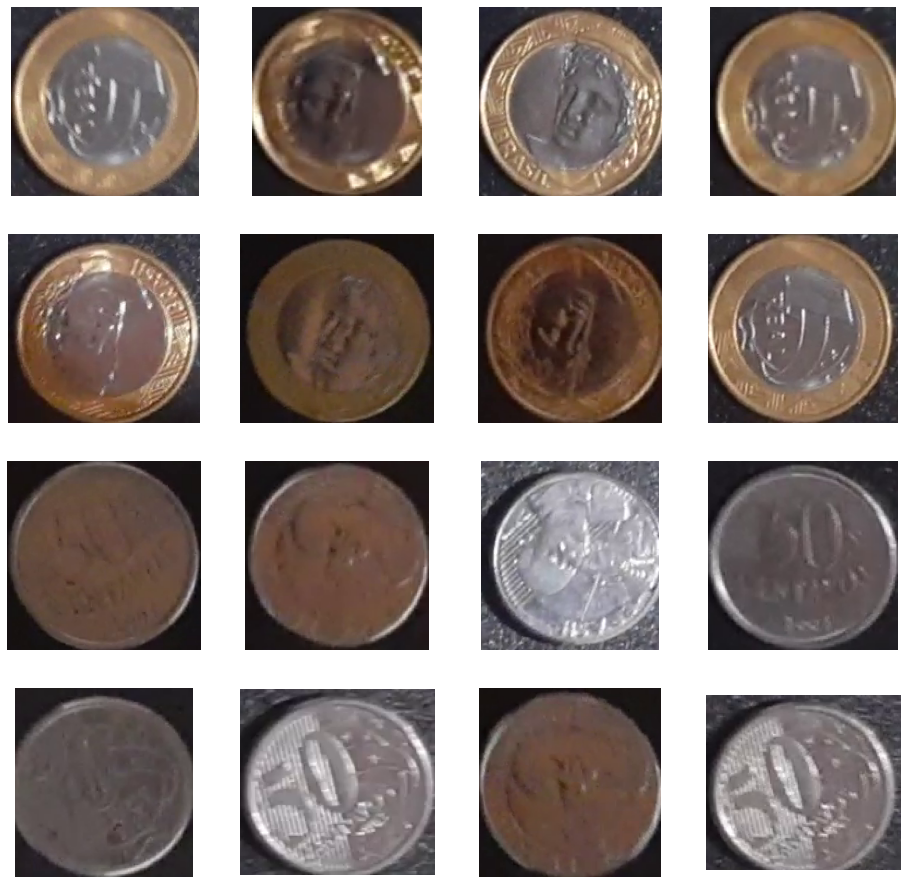

In [ ]:
#@title Show some coins
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 4
ncols = 4
# Directory with our training 050 pictures
train_050_dir = os.path.join(train_dir, '050')
# Directory with our training 100 pictures
train_100_dir = os.path.join(train_dir, '100')
train_100_fnames = os.listdir(train_100_dir)
train_050_fnames = os.listdir(train_050_dir)
pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_100_pix = [os.path.join(train_100_dir, fname) 
                for fname in train_100_fnames[pic_index-8:pic_index]]
next_050_pix = [os.path.join(train_050_dir, fname) 
                for fname in train_050_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_100_pix+next_050_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

## Building a Small Convnet from Scratch

Resize all images to 100x100 pixels, so that will be the input size to the neural network.<p>
Define a **shallow** network (there are few training examples, easy to overfit if too much capacity).<p>
Notice that the actual purpose of the Conv layers is **extracting features to classify some coins** (we'll then do transfer learning for our UK coins). Define the final fully-connected layers in a separate step.<p>
You might wish to add regularization to some layers as well, to do so plesae check: https://keras.io/api/layers/regularizers/

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers #for regularization

In [ ]:
# Input feature map is 100x100x3 colour channels
img_input = layers.Input(shape=(100, 100, 3))

#ADD INTERMEDIATE CONV + POOLING LAYERS                                                 
#Intermediate CONV

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)






#DON'T ADD FINAL LAYERS AT THIS STEP, USE THE NEXT ONE


Now **flatten** the feature map and add a couple dense (fully connected) layers. The final one needs **5 outputs** as we're doing a 5-class classification.<p>
<u>We can no longer use a sigmoid output</u> (that handles only 2 classes). See aother vailable activations in https://keras.io/api/layers/activations/
You can add regularization, and also dropout right before the final layer to improve generalization (reduce overfitting)

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
#update x with the output name of the previous step if different
                              
x = layers.Flatten()(x)
x = layers.Dropout(0.2, input_shape = (100, 100, 3))(x)     
# ADD HIDDEN AND FINAL DENSE LAYERS
# OUTPUT LAYERS NEEDS 5 NODES (one per class). 'sigmoid' ACTIVATION NO LONGER SUITABLE
x = layers.Dense(256, activation='relu', kernel_regularizer='l1')(x)           
output = layers.Dense(5, activation='softmax')(x)   

# Create model:
model = Model(img_input, output)

Let's summarize the model architecture. NOTICE THE LAYER NAMES, you'll need them later on:

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 128)       7385

Next, we'll configure the specifications for model training, using Keras [model.compile](https://keras.io/api/models/model_training_apis/#compile-method) method.<p>
Don't train our model with the `binary_crossentropy` loss, because the final activation cannot be a sigmoid. Check https://keras.io/api/losses/ for alternative **loss** metrics suitable for your new activation.<p>
We can use RMSprop optimizer algorithm `rmsprop`, learning rate commonly 0.001. During training, we will want to monitor classification accuracy. Other available optimizers: https://keras.io/api/optimizers/

In [ ]:
from tensorflow.keras.optimizers import Adam
# use categorical crossentropy loss
model.compile(loss='categorical_crossentropy', #loss metric
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), # Adam Optimizer Used
              metrics=['acc']) #metrics to monitor during training ('acc' = accuracy)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels 0, 1, 2, ... corresponding to each of the supplied subdirectories) to our network. As our data is split in train and validation folders, we need one generator for the training images and one for the validation images.<p>
Our generators will yield batches of B images and their labels.<p>
Preprocess the images by normalizing the pixel values to be in the `[0.0, 1.0]` range (dividing by 255.0). We can also benefit of **data augmentation** to account for more variability. Rotations are really important as new coins may appear rotated during future inference.<p>
In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class. To find out more augmentation options, check https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator. <p>
We also need to set class_mode to `categorical` (no longer `binary`)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255 and augmented
train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
                               
val_datagen = ImageDataGenerator(rescale=1./255) #do not augment validation
B = 15 #Batch size
# Flow training images in batches of B using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size = (100, 100),  # All images will be resized to 100x100
        batch_size=B,
        # To use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(100, 100),
        batch_size=B,
        class_mode='categorical')

Found 765 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


### Training
Let's train on all 765 images available, for 15 epochs, and validate on all 300 validation images. (This may take a few minutes to run).<p>
If the training accuracy is significantly better than validation accuracy, the model is overfitting, you should include regularization and dropout.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=765//B,  # 765 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=300//B,  # 300 images = batch_size * steps
      verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
51/51 - 20s - loss: 277.7837 - acc: 0.2392 - val_loss: 206.4382 - val_acc: 0.2567 - 20s/epoch - 385ms/step
Epoch 2/20
51/51 - 18s - loss: 150.6225 - acc: 0.2510 - val_loss: 99.2833 - val_acc: 0.2233 - 18s/epoch - 361ms/step
Epoch 3/20
51/51 - 19s - loss: 62.8555 - acc: 0.2941 - val_loss: 31.6902 - val_acc: 0.4100 - 19s/epoch - 381ms/step
Epoch 4/20
51/51 - 18s - loss: 14.6753 - acc: 0.3621 - val_loss: 3.6374 - val_acc: 0.3967 - 18s/epoch - 363ms/step
Epoch 5/20
51/51 - 19s - loss: 2.4662 - acc: 0.3373 - val_loss: 2.1005 - val_acc: 0.3400 - 19s/epoch - 367ms/step
Epoch 6/20
51/51 - 19s - loss: 2.0857 - acc: 0.3490 - val_loss: 2.0762 - val_acc: 0.4100 - 19s/epoch - 365ms/step
Epoch 7/20
51/51 - 19s - loss: 2.0764 - acc: 0.3647 - val_loss: 2.2096 - val_acc: 0.2667 - 19s/epoch - 364ms/step
Epoch 8/20
51/51 - 19s - loss: 2.1087 - acc: 0.3712 - val_loss: 2.0486 - val_acc: 0.3967 - 19s/epoch - 365ms/step
Epoch 9/20
51/51 - 19s - loss: 2.0992 - acc: 0.3830 - val_loss: 2.0913 - val_a

---

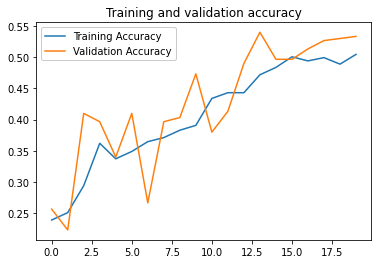

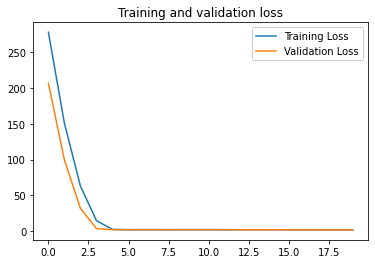

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label ='Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(framealpha=1, frameon=True)
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend(framealpha=1, frameon=True)

#Now let's transfer this to our UK coins
We have a very limited collecton of UK coin examples (slightly above 300) split in 8 subdirectories, one for each  class. Let's apply transfer learning from our Brazilian coins.

In [ ]:
!wget https://edshare.gcu.ac.uk/id/document/61325 \
      -O /content/UK_coins_ClassSplit.zip 

--2022-05-02 02:12:31--  https://edshare.gcu.ac.uk/id/document/61325
Resolving edshare.gcu.ac.uk (edshare.gcu.ac.uk)... 193.62.226.109
Connecting to edshare.gcu.ac.uk (edshare.gcu.ac.uk)|193.62.226.109|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://edshare.gcu.ac.uk/9959/1/UK_coins_Mario_ClassSplit.zip [following]
--2022-05-02 02:12:31--  https://edshare.gcu.ac.uk/9959/1/UK_coins_Mario_ClassSplit.zip
Connecting to edshare.gcu.ac.uk (edshare.gcu.ac.uk)|193.62.226.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2212692 (2.1M) [application/zip]
Saving to: ‘/content/UK_coins_ClassSplit.zip’

/content/UK_coins_C 100%[===================>]   2.11M   894KB/s    in 2.4s    

2022-05-02 02:12:34 (894 KB/s) - ‘/content/UK_coins_ClassSplit.zip’ saved [2212692/2212692]



In [ ]:
local_zip = '/content/UK_coins_ClassSplit.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()
UK_base_dir = './UK_coins_Mario_ClassSplit'

Take a look to some UK coin images:

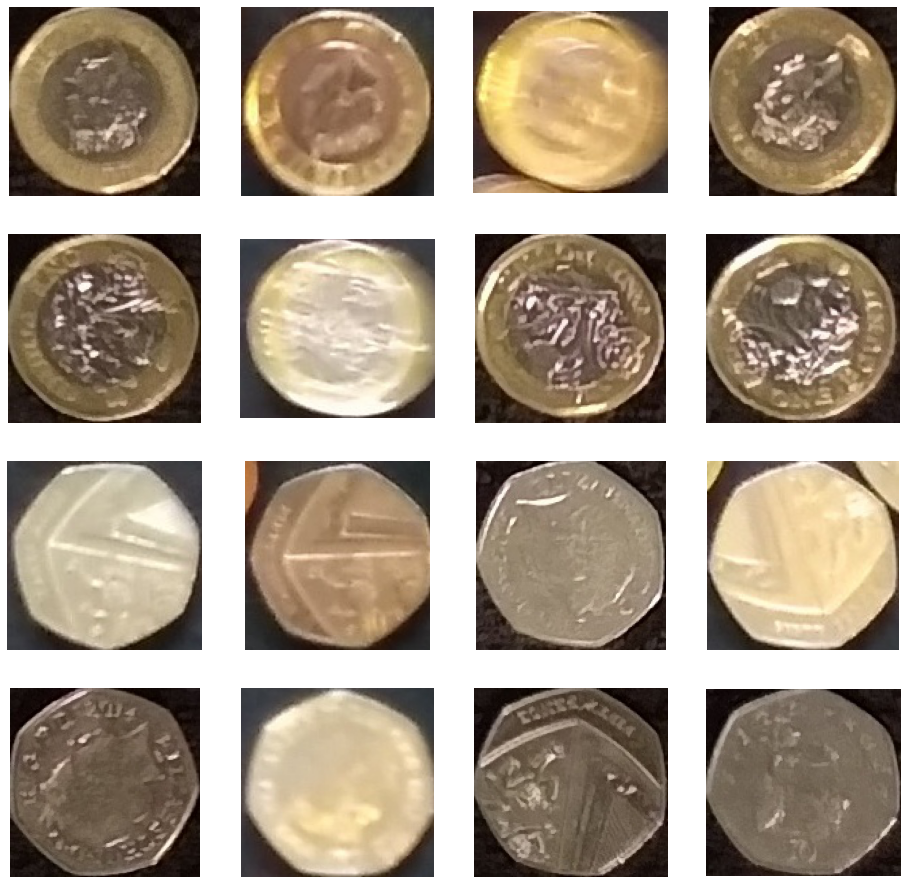

In [ ]:
#@title Show some coins
UK_100_dir = os.path.join(UK_base_dir, '100')
UK_050_dir = os.path.join(UK_base_dir, '050')
nrows = 4
ncols = 4
train_100_fnames = os.listdir(UK_100_dir)
train_050_fnames = os.listdir(UK_050_dir)
pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_100_pix = [os.path.join(UK_100_dir, fname) 
                for fname in train_100_fnames[pic_index-8:pic_index]]
next_050_pix = [os.path.join(UK_050_dir, fname) 
                for fname in train_050_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_100_pix+next_050_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

Load the training data. Notice that this time the data is not pre-split in "train" and "validation" directories. We can do an automatic train/validation split as determined by parameter `validation_split`.<p>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255 and augmented
UK_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=90,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                validation_split=0.2)  #makes random split, 20% for validation
B = 10 #Batch size
# Extract flow training images in batches of B images
UK_train_generator = UK_datagen.flow_from_directory(
        UK_base_dir,  # This is the source directory for training images
        target_size = (100, 100),  # All images will be resized to 100x100
        batch_size=B,
        subset = 'training',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')
# Extract flow validation images in batches of B images
UK_validation_generator = UK_datagen.flow_from_directory(
        UK_base_dir,
        target_size=(100, 100),
        batch_size=B,
        subset = 'validation',
        class_mode='categorical')

Found 250 images belonging to 8 classes.
Found 59 images belonging to 8 classes.


Now we freeze all layers of our Brazilian CNN, so they don't get re-trained:

In [ ]:
for layer in model.layers:
  print('freezing ' + layer.name)
  layer.trainable = False

freezing input_1
freezing conv2d
freezing max_pooling2d
freezing conv2d_1
freezing max_pooling2d_1
freezing conv2d_2
freezing max_pooling2d_2
freezing flatten
freezing dropout
freezing dense
freezing dense_1


Next, replace the last FC layers (right after flattening) by new ones. **Output needs now 8 classes now!**<p>
Check the layer names to select the desired replacement point.

In [ ]:
replace_point = model.get_layer('dense_1') #layer after which we'll add new ones
#CONNECT NEW DENSE LAYERS TO (replace_point.output)

#FINAL LAYER NEEDS 8 nodes (one per class)
x = layers.Dense(128, activation='relu')(x)
UKoutput = layers.Dense(8, activation='softmax')(x)   #was 5 (preferred) 


# Create UK coins model:
UKmodel = Model(img_input, UKoutput)

Get a summary of the updated  UK model. Is should show a number of non-trainable parameters (those from the frozen layers). The transferred layers should have the same names they had in the original model, added layers will get new names.

In [ ]:
UKmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       7385

Compile the new model. Remember that we need to use a reduced learning rate (like 1/10 of the original one)

In [ ]:
UKmodel.compile(loss='categorical_crossentropy', #loss metric
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), #decreased learning rate
              metrics=['acc']) #metrics to monitor during training ('acc' = accuracy)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train the added layers on our UK coins. We are assuming that the Brazilian coin features extracted by the frozen layers will also be useful for the UK coins...

In [ ]:
history = UKmodel.fit_generator(
      UK_train_generator,
      steps_per_epoch=250//B,  # 250 train images = batch_size * steps
      epochs=40,
      validation_data=UK_validation_generator,
      validation_steps=59/B,  # 59 validation images = batch_size * steps
      verbose=2)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


25/25 - 3s - loss: 2.8700 - acc: 0.0920 - val_loss: 2.7727 - val_acc: 0.1017 - 3s/epoch - 132ms/step
Epoch 2/40
25/25 - 3s - loss: 2.7835 - acc: 0.0920 - val_loss: 2.7022 - val_acc: 0.1017 - 3s/epoch - 102ms/step
Epoch 3/40
25/25 - 3s - loss: 2.7329 - acc: 0.1480 - val_loss: 2.6567 - val_acc: 0.2034 - 3s/epoch - 100ms/step
Epoch 4/40
25/25 - 3s - loss: 2.6703 - acc: 0.1600 - val_loss: 2.6145 - val_acc: 0.2712 - 3s/epoch - 101ms/step
Epoch 5/40
25/25 - 3s - loss: 2.6266 - acc: 0.2000 - val_loss: 2.5646 - val_acc: 0.3051 - 3s/epoch - 101ms/step
Epoch 6/40
25/25 - 3s - loss: 2.5768 - acc: 0.2720 - val_loss: 2.5248 - val_acc: 0.3220 - 3s/epoch - 101ms/step
Epoch 7/40
25/25 - 3s - loss: 2.5425 - acc: 0.2640 - val_loss: 2.4878 - val_acc: 0.3559 - 3s/epoch - 101ms/step
Epoch 8/40
25/25 - 3s - loss: 2.5092 - acc: 0.2840 - val_loss: 2.4602 - val_acc: 0.3898 - 3s/epoch - 102ms/step
Epoch 9/40
25/25 - 2s - loss: 2.4787 - acc: 0.3080 - val_loss: 2.4473 - val_acc: 0.4068 - 2s/epoch - 100ms/step
Epo

You might try to improve a bit by unfreezing the last imported Conv layer as well, and retrain some more with a heavily reduced learning rate (1/100 of the original)<p>
Check the layers names and update them as needed.

In [ ]:
unfreeze = False
for layer in UKmodel.layers:
  if layer.name == 'conv2d_2': #first layer to unfreeze
    print('--- unfreezing ---')
    unfreeze = True
  if unfreeze:
    layer.trainable = True
  print(layer.name)

input_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
--- unfreezing ---
conv2d_2
max_pooling2d_2
flatten
dropout
dense
dense_2
dense_3


In [ ]:
#show model again. Compare thenumber of non-trainable parameters with previous versions
UKmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       7385

Finally, fine-tune with Stochastic Gradient Descent with very low leraning rate for 50 epochs

In [ ]:
# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
from tensorflow.keras.optimizers import SGD
UKmodel.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = UKmodel.fit_generator(
      UK_train_generator,
      steps_per_epoch=250//B,  # 221 images = batch_size * steps
      epochs=50,
      validation_data=UK_validation_generator,
      validation_steps=59//B,  # 88 images = batch_size * steps
      verbose=2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


25/25 - 5s - loss: 2.9386 - acc: 0.3360 - val_loss: 2.5437 - val_acc: 0.3400 - 5s/epoch - 183ms/step
Epoch 2/50
25/25 - 4s - loss: 2.3713 - acc: 0.4160 - val_loss: 2.3676 - val_acc: 0.3600 - 4s/epoch - 150ms/step
Epoch 3/50
25/25 - 4s - loss: 2.2091 - acc: 0.4120 - val_loss: 2.2190 - val_acc: 0.4400 - 4s/epoch - 150ms/step
Epoch 4/50
25/25 - 4s - loss: 2.1946 - acc: 0.3960 - val_loss: 2.1786 - val_acc: 0.6000 - 4s/epoch - 149ms/step
Epoch 5/50
25/25 - 4s - loss: 2.0959 - acc: 0.4040 - val_loss: 2.2502 - val_acc: 0.5600 - 4s/epoch - 151ms/step
Epoch 6/50
25/25 - 4s - loss: 2.1551 - acc: 0.3800 - val_loss: 2.3344 - val_acc: 0.4200 - 4s/epoch - 151ms/step
Epoch 7/50
25/25 - 4s - loss: 2.1405 - acc: 0.3440 - val_loss: 2.1988 - val_acc: 0.5400 - 4s/epoch - 151ms/step
Epoch 8/50
25/25 - 4s - loss: 2.0926 - acc: 0.3320 - val_loss: 2.3520 - val_acc: 0.3200 - 4s/epoch - 149ms/step
Epoch 9/50
25/25 - 4s - loss: 2.0980 - acc: 0.3920 - val_loss: 2.2259 - val_acc: 0.4200 - 4s/epoch - 149ms/step
Epo

With 
Adam optimiser + Dropout (0.2) + Kernal Reg l1 + 4 convolution layers + softmax classify = 0.50acc and 0.58 val acc
" " Dropout(0.5) - acc 0.46/47 and val acc 0.55 - worse off higher dropout 



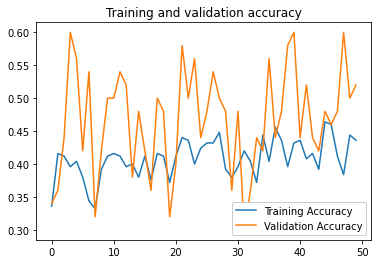

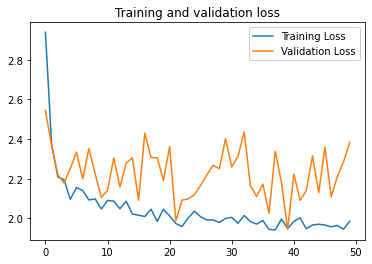

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label ='Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(framealpha=1, frameon=True)
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend(framealpha=1, frameon=True)

# Inference
That should be the classifier ready. If you wish, try to play inference on a new image using UKmodel.predict
https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

In [ ]:
#ADDED BY MARIO
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
#upload a new coin image and try to classify it
fname = "./New_Coin.png" #update name as needed
img = load_img(fname, target_size=(100, 100))
x = img_to_array(img)  # Numpy array with shape (100, 100, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 100, 100, 3)
# Rescale by 1/255
x /= 255
# Let's run our image through our network
prediction = UKmodel.predict(x)
prediction
#class numbers corresponds to subdirectories (train_datagen.flow_from_directory uses alphabetic order by default)

array([[0.4139336 , 0.307838  , 0.00422083, 0.00709299, 0.01827327,
        0.01042282, 0.06306059, 0.17515792]], dtype=float32)